# Logistic Regression - Multiclass Classification - Stochastic Gradient Descent

In this notebook, we apply the **Stochastic Gradient Descent (SGD)** algorithm for solving a multi-class classification problem using the Logistic Regression model. We study the impact of two types of regularization:

- L2/L1
- L2/L1 & Early Stopping


###  Early Stopping

Early stopping is a regularization technique for iterative optimization algorithms such as Graient Descent that stops training as soon as the validation error reaches a minimum. 

Because we start with zero or near zero weights and they move away as training continues, stopping early corresponds to a model with more weights close to zero and effectively fewer parameters.

### Early Stopping Curve:

With Stochastic (and Mini-batch) Gradient Descent, the error vs iterations (epochs) curves are not so smooth.

It may be hard to know whether we have reached the minimum or not. 

One solution is to stop only after the validation error has been above the minimum for some time (when we are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.

More on Stochastic Gradient Descent:
https://scikit-learn.org/stable/modules/sgd.html#sgd

# Dataset


We will use the iris dataset, which is a multivariate data set. 

This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica

There are 4 features: 
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)

Total number of samples: 150

The dataset is also known as Fisher's Iris data set as it was introduced by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis".


<img src="https://cse.unl.edu/~hasan/IrisFlowers.png" width=800, height=400>

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Explore The Dataset

In [2]:
iris = load_iris()

# See the key values
print("\nKey Values: \n", list(iris.keys()))

# The feature names
print("\nFeature Names: \n", list(iris.feature_names))

# The target names
print("\nTarget Names: \n", list(iris.target_names))

# The target values (codes)
#print("\nTarget Values: \n", list(iris.target))


Key Values: 
 ['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

Feature Names: 
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target Names: 
 ['setosa', 'versicolor', 'virginica']


## Create Data Matrix (X) and the Label Array (y)

We can use all features or a subset. For this notebook, we will use two features (i.e., petal length, petal width).

In [3]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

print(X.shape)
print(y.shape)

print("\nX data type: ", X.dtype)
print("y data type: ", y.dtype)

(150, 2)
(150,)

X data type:  float64
y data type:  int64


## Split Data Into Training and Test Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Standardize the Data

In [5]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Stochastic Gradient Descent


The main problem with Batch Gradient Descent is that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. 

At the opposite extreme, Stochastic Gradient Descent just picks a random instance in the training set at every step and computes the gradients based only on that single instance. 

Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration.

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. 

Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. So once the algorithm stops, the final parameter values are good, but not optimal.

## Scikit-Learn SGDClassifier


The SGDClassifier implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties for classification.

The concrete loss function can be set via the loss parameter. SGDClassifier supports the following loss functions:

- loss="hinge": (soft-margin) linear Support Vector Machine
- loss="modified_huber": smoothed hinge loss
- loss="log": logistic regression

For implementing SGD for Logistic Regression, we usually use the "log" loss. The "log" loss gives logistic regression, a probabilistic classifier.

Using loss="log" enables the predict_proba method, which gives a vector of probability estimates per sample.



We need to set the following attributes to train a SGDClassifier.


- penalty : ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’
    -- The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’.
    

- alpha : Constant that multiplies the regularization term. Defaults to 0.0001 


- l1_ratio : The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1. Defaults to 0.15.


- max_iter : The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit. Defaults to 5. Defaults to 1000 from 0.21, or if tol is not None.


- tol : The stopping criterion. If it is not None, the iterations will stop when (loss > previous_loss - tol). Defaults to 1e-3 from 0.21.


- random_state : The seed of the pseudo random number generator to use when shuffling the data. If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.


- learning_rate : The learning rate schedule:

    -- ‘constant’: eta = eta0

    --‘optimal’: [default] eta = 1.0 / (alpha * (t + t0)) where t0 is chosen by a heuristic proposed by Leon Bottou.

    --‘invscaling’: eta = eta0 / pow(t, power_t)

    --‘adaptive’: eta = eta0, as long as the training keeps decreasing. Each time n_iter_no_change consecutive epochs fail to decrease the training loss by tol or fail to increase validation score by tol if early_stopping is True, the current learning rate is divided by 5.


- eta0 : The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. The default value is 0.0 as eta0 is not used by the default schedule ‘optimal’.



- early_stopping : Whether to use early stopping to terminate training when validation score is not improving. If set to True, it will automatically set aside a fraction of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.


- n_iter_no_change : Number of iterations with no improvement to wait before early stopping.

More detail: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


## SGDClassifier for Multi-Class Classification

SGDClassifier supports multi-class classification by combining multiple binary classifiers in a **“one versus all” (OvA)** scheme. 

For each of the classes, a binary classifier is learned that discriminates between that and all other classes. 

At testing time, we compute the confidence score (i.e. the signed distances to the hyperplane) for each classifier and choose the class with the highest confidence. 

- Note that the Logistic Regression SGDClassifier **does not use the Softmax regression** technique for multi-class classification.

## Investigation of the Stochastic Gradient Descent for Logistic Regression

We will investigate the SGDClassifier:
- Without Early Stopping
- With Early Stopping

## Stochastic Gradient Descent Without Early Stopping

We implement the SGDClassifier without early stopping.


First, we need to find the optimal hyperparameters via Gridsearch.

## Model Selection: Hyperparameter Tuning

- For logistic regression, the loss function should be set to "log".

In [6]:
%%time

warnings.filterwarnings('ignore')

param_grid = {'alpha': [0.05, 0.01, 0.001],
              'penalty' : ["l2", "l1"],
              'learning_rate': ["constant", "optimal", "invscaling", "adaptive"], 
              'max_iter':[500, 1000, 3000],
              'eta0': [0.1, 0.01, 0.001],
              'tol': [1e-3, 1e-5, 1e-8]}

sgd_clf = SGDClassifier(loss='log') # for logistic regression, the loss function should be "log"

sgd_clf_cv = GridSearchCV(sgd_clf, param_grid, scoring='f1_micro', cv=3, verbose=1, n_jobs=-1)
sgd_clf_cv.fit(X_train, y_train)

params_optimal = sgd_clf_cv.best_params_

print("Best Score (F1 micro): %f" % sgd_clf_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s


Best Score (F1 micro): 0.975000
Optimal Hyperparameter Values:  {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'optimal', 'max_iter': 500, 'penalty': 'l1', 'tol': 1e-08}


CPU times: user 1.87 s, sys: 126 ms, total: 2 s
Wall time: 8.57 s


[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:    8.5s finished


## Train the Optimal SGDClassifier without Early Stopping

In [7]:
sgd = SGDClassifier(loss='log', **params_optimal)
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-08,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Evaluate the Optimal SGDClassifier without Early Stopping on Test Data

In [8]:
print("\nNo. of Iterations:", sgd.n_iter_ )

print("\nWeight Coefficients:\n", sgd.coef_ )

print("\nWeight Intercept:\n", sgd.intercept_ )


y_test_predict = sgd.predict(X_test)
#print(y_test_predict)

accuracy_score_test = np.mean(y_test_predict == y_test)
print("\nTest Accuracy: ", accuracy_score_test)

# Confusion Matrix
print("\nTest Confusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predict))


No. of Iterations: 159

Weight Coefficients:
 [[-5.66985035 -3.83413499]
 [ 3.46148009 -2.01606661]
 [ 8.32181086  7.66479621]]

Weight Intercept:
 [ -5.96587008  -0.62429476 -10.35769218]

Test Accuracy:  1.0

Test Confusion Matrix (Test Data):
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


## Stochastic Gradient Descent With Early Stopping


We implement the Logistic Regression SGDClassifier with early stopping.

First, we need to find the optimal hyperparameters via Gridsearch.


## Model Selection: Hyperparameter Tuning

- For logistic regression, the loss function should be set to "log".

In [9]:
%%time

warnings.filterwarnings('ignore')

param_grid = {'alpha': [0.05, 0.01, 0.001],
              'penalty' : ["l2", "l1"],
              'learning_rate': ["constant", "optimal", "invscaling", "adaptive"], 
              'max_iter':[100, 500, 1000, 3000],
              'eta0': [0.01, 0.001],
              'tol': [1e-3, 1e-5, 1e-8]}


sgd_clf_es = SGDClassifier(loss='log', early_stopping=True)

sgd_clf_es_cv = GridSearchCV(sgd_clf_es, param_grid, scoring='f1_micro', cv=3, verbose=1, n_jobs=-1)
sgd_clf_es_cv.fit(X_train, y_train)

params_optimal_es = sgd_clf_es_cv.best_params_

print("Best Score (F1 Micro): %f" % sgd_clf_es_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_es)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.5s


Best Score (F1 Micro): 0.975000
Optimal Hyperparameter Values:  {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 500, 'penalty': 'l1', 'tol': 1e-08}


CPU times: user 1.93 s, sys: 58.5 ms, total: 1.99 s
Wall time: 8.89 s


[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:    8.9s finished


## Train the Optimal SGDClassifier with Early Stopping

In [10]:
sgd_early_stopping = SGDClassifier(loss='log', early_stopping=True, **params_optimal_es)

sgd_early_stopping.fit(X_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, early_stopping=True,
              epsilon=0.1, eta0=0.01, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-08,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Evaluate the Optimal SGDClassifier with Early Stopping on Test Data

In [11]:
print("\nNo. of Iterations:", sgd_early_stopping.n_iter_ )

print("\nWeight Coefficients:\n", sgd_early_stopping.coef_ )

print("\nWeight Intercept:\n", sgd_early_stopping.intercept_ )

y_test_predict = sgd_early_stopping.predict(X_test)
#print(y_test_predict)

accuracy_score_test = np.mean(y_test_predict == y_test)
print("\nTest Accuracy: ", accuracy_score_test)

# Confusion Matrix
print("\nTest Confusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predict))


No. of Iterations: 6

Weight Coefficients:
 [[-3.04289864 -2.35491709]
 [ 1.27767328 -0.66066751]
 [ 2.74404443  4.01486595]]

Weight Intercept:
 [-3.24240572 -0.60137879 -4.27290212]

Test Accuracy:  1.0

Test Confusion Matrix (Test Data):
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


## Comparision: Early Stopping & Without Early Stopping

In [12]:
print("\nWeight Coefficients (Without Early Stopping):\n", sgd.coef_ )
print("\nWeight Coefficients (Early Stopping):\n", sgd_early_stopping.coef_)

print("\nNo. of Iterations (Without Early Stopping):", sgd.n_iter_ )
print("No. of Iterations (Early Stopping):", sgd_early_stopping.n_iter_ )


Weight Coefficients (Without Early Stopping):
 [[-5.66985035 -3.83413499]
 [ 3.46148009 -2.01606661]
 [ 8.32181086  7.66479621]]

Weight Coefficients (Early Stopping):
 [[-3.04289864 -2.35491709]
 [ 1.27767328 -0.66066751]
 [ 2.74404443  4.01486595]]

No. of Iterations (Without Early Stopping): 159
No. of Iterations (Early Stopping): 6


## Observation: Early Stopping Regularization

The SGDClassifier (or any gradient descent algorithm) starts with zero or near-zero weights. Then, it moves away as training continues. If we stop the training early, as soon as the validation error reaches minimum, we get a model with **more weights close to zero and effectively fewer parameters**.

If we compare the weight coefficients and the number iterations between the two implementations (without and with early stopping), we will see the difference. 

Early stopping makes the weights smaller (enables feature selection) and requires less iterations (faster training time). 

However, due to its stochastic nature we will not always get optimal weights. Hence the model performance will not be as good as the batch gradient descent based approach.

With smaller dataset (e.g., Iris), we will not see the benefit of SGDclassifier with early stopping. However, for larger datasets (e.g., MNIST handwritten digit recongnition), the SGDClassifier will improve the model performance in two ways:

- Faster training time
- Feature selection (due to early stopping as well as l2 regularization)

# Decision Bounday 

We plot the decision boundary learned by both models.

We use the function "decision_boundary_class_colored" to plot the decision boundary. Note that for multi-class classification, the "plotDistanceFromHyperplane" attribute should be set to False.

A detail discussion on this function is provided in the "Logistic Regression-1-Binary Classification" notebook.

In [13]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    #plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)
    
        
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)    

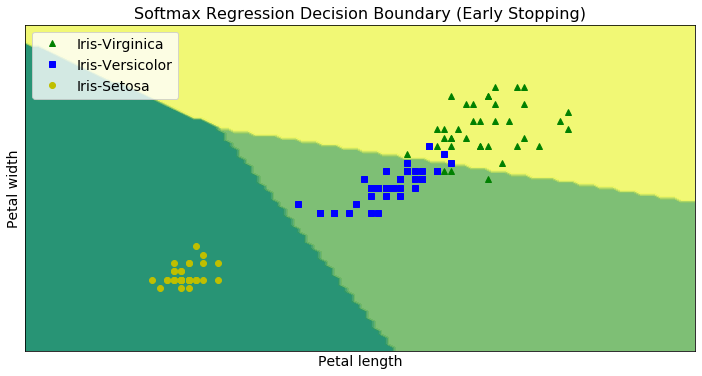

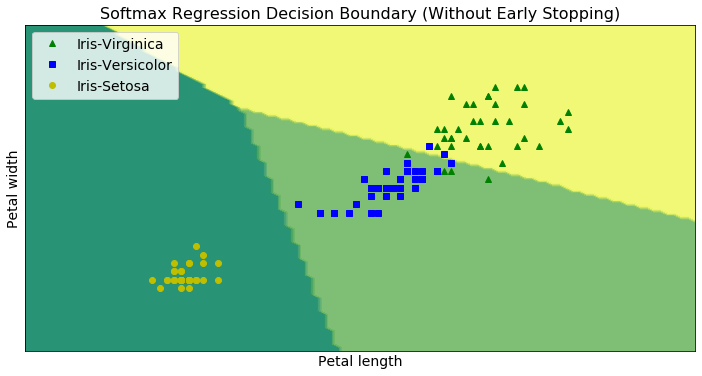

In [14]:
plt.figure(figsize=(12, 6))

decision_boundary_class_colored(sgd_early_stopping, X_train, plotDistanceFromHyperplane=False)


plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "yo", label="Iris-Setosa")


plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("Softmax Regression Decision Boundary (Early Stopping)", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

plt.figure(figsize=(12, 6))

decision_boundary_class_colored(sgd, X_train, plotDistanceFromHyperplane=False)


plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "yo", label="Iris-Setosa")


plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("Softmax Regression Decision Boundary (Without Early Stopping)", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()